# Error Bar Detection in Scientific Charts
## OpenCV + Geometry-Based Deterministic Pipeline

**Objective:** Detect error bars in scientific chart images using computer vision techniques.

**Approach:**
- ROI-based vertical line detection around data points
- Edge detection and contour analysis
- Geometric measurements for pixel-accurate error bar distances
- Evaluation against ground truth annotations

## 1. Setup and Imports

In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Tuple
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Configuration and Data Paths

In [2]:
# Data paths (Kaggle format)
BASE_PATH = "/kaggle/input/graph-plots"
TEST_IMAGES = os.path.join(BASE_PATH, "Test", "images")
TEST_INPUT_LABELS = os.path.join(BASE_PATH, "Test", "test_labels")  # Input: x,y only
TEST_GROUND_TRUTH = os.path.join(BASE_PATH, "Test", "labels")       # Ground truth: with error bars

# Detection parameters
ROI_WIDTH = 30      # Horizontal search region around data point
ROI_HEIGHT = 150    # Vertical search region above/below data point
MIN_LINE_LENGTH = 5 # Minimum vertical line length to consider
EDGE_THRESHOLD1 = 50
EDGE_THRESHOLD2 = 150

print(f"Test images: {TEST_IMAGES}")
print(f"Test input labels: {TEST_INPUT_LABELS}")
print(f"Ground truth: {TEST_GROUND_TRUTH}")

Test images: /kaggle/input/graph-plots/Test/images
Test input labels: /kaggle/input/graph-plots/Test/test_labels
Ground truth: /kaggle/input/graph-plots/Test/labels


## 3. Helper Functions

In [3]:
def load_test_input(json_path):
    """Load test input JSON (contains only x,y coordinates)"""
    with open(json_path, 'r') as f:
        return json.load(f)

def load_ground_truth(json_path):
    """Load ground truth JSON (contains error bar distances)"""
    with open(json_path, 'r') as f:
        return json.load(f)

def visualize_detection(image, point, top_dist, bottom_dist, title=""):
    """Visualize detected error bars on image"""
    img_copy = image.copy()
    x, y = int(point['x']), int(point['y'])
    
    # Draw data point
    cv2.circle(img_copy, (x, y), 5, (0, 255, 0), -1)
    
    # Draw error bars if detected
    if top_dist > 0:
        top_y = int(y - top_dist)
        cv2.line(img_copy, (x, y), (x, top_y), (255, 0, 0), 2)
        cv2.line(img_copy, (x-5, top_y), (x+5, top_y), (255, 0, 0), 2)
    
    if bottom_dist > 0:
        bottom_y = int(y + bottom_dist)
        cv2.line(img_copy, (x, y), (x, bottom_y), (0, 0, 255), 2)
        cv2.line(img_copy, (x-5, bottom_y), (x+5, bottom_y), (0, 0, 255), 2)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

print("Helper functions defined!")

Helper functions defined!


## 4. Error Bar Detection Algorithm

In [4]:
def detect_vertical_lines_in_roi(image, x, y, roi_width, roi_height):
    """
    Detect vertical lines in ROI around a data point.
    Returns list of vertical line segments as (x, y1, y2)
    """
    h, w = image.shape[:2]
    
    # Define ROI boundaries
    x1 = max(0, int(x - roi_width))
    x2 = min(w, int(x + roi_width))
    y1 = max(0, int(y - roi_height))
    y2 = min(h, int(y + roi_height))
    
    # Extract ROI
    roi = image[y1:y2, x1:x2]
    
    if roi.size == 0:
        return []
    
    # Convert to grayscale if needed
    if len(roi.shape) == 3:
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        gray_roi = roi.copy()
    
    # Edge detection
    edges = cv2.Canny(gray_roi, EDGE_THRESHOLD1, EDGE_THRESHOLD2)
    
    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=20, 
                           minLineLength=MIN_LINE_LENGTH, maxLineGap=3)
    
    vertical_lines = []
    if lines is not None:
        for line in lines:
            x1_l, y1_l, x2_l, y2_l = line[0]
            
            # Check if line is vertical (small horizontal change)
            dx = abs(x2_l - x1_l)
            dy = abs(y2_l - y1_l)
            
            if dy > dx * 3:  # Line is more vertical than horizontal
                # Convert back to image coordinates
                img_x = x1 + (x1_l + x2_l) // 2
                img_y1 = y1 + min(y1_l, y2_l)
                img_y2 = y1 + max(y1_l, y2_l)
                vertical_lines.append((img_x, img_y1, img_y2))
    
    return vertical_lines

print("Vertical line detection function defined!")

Vertical line detection function defined!


In [5]:
def detect_error_bars(image, point, roi_width=ROI_WIDTH, roi_height=ROI_HEIGHT):
    """
    Detect error bars for a single data point.
    Returns: (topBarPixelDistance, bottomBarPixelDistance, deviationPixelDistance)
    """
    x, y = point['x'], point['y']
    
    # Detect vertical lines in ROI
    vertical_lines = detect_vertical_lines_in_roi(image, x, y, roi_width, roi_height)
    
    top_distance = 0.0
    bottom_distance = 0.0
    
    # Find lines close to the data point
    for line_x, line_y1, line_y2 in vertical_lines:
        # Check if line is close to data point horizontally
        if abs(line_x - x) < 10:  # Within 10 pixels horizontally
            # Check if line extends above the data point
            if line_y1 < y < line_y2:
                # Error bar crosses the data point
                top_distance = max(top_distance, y - line_y1)
                bottom_distance = max(bottom_distance, line_y2 - y)
            elif line_y2 < y:
                # Line is above data point
                top_distance = max(top_distance, y - line_y2)
            elif line_y1 > y:
                # Line is below data point
                bottom_distance = max(bottom_distance, line_y1 - y)
    
    # DeviationPixelDistance is max of top and bottom
    deviation_distance = max(top_distance, bottom_distance)
    
    return top_distance, bottom_distance, deviation_distance

print("Error bar detection function defined!")

Error bar detection function defined!


In [6]:
def process_image(image_path, input_json):
    """
    Process a single image and detect error bars for all data points.
    Returns predictions in the same format as ground truth.
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None
    
    predictions = []
    
    # Process each line/series in the data
    for data_line in input_json.get('data_points', []):
        line_name = data_line.get('lineName', '')
        points = data_line.get('points', [])
        
        predicted_points = []
        
        for point in points:
            # Detect error bars
            top_dist, bottom_dist, dev_dist = detect_error_bars(image, point)
            
            # Build prediction point
            pred_point = {
                "x": point['x'],
                "y": point['y'],
                "label": "",
                "topBarPixelDistance": float(top_dist),
                "bottomBarPixelDistance": float(bottom_dist),
                "deviationPixelDistance": float(dev_dist)
            }
            predicted_points.append(pred_point)
        
        # Add line prediction
        predictions.append({
            "label": {"lineName": line_name},
            "points": predicted_points
        })
    
    return predictions

print("Image processing function defined!")

Image processing function defined!


## 5. Evaluation Metrics

In [7]:
def calculate_point_error(pred_point, gt_point):
    """
    Calculate absolute pixel error for a single point.
    Returns dict with error metrics.
    """
    top_error = abs(pred_point.get('topBarPixelDistance', 0) - 
                   gt_point.get('topBarPixelDistance', 0))
    bottom_error = abs(pred_point.get('bottomBarPixelDistance', 0) - 
                      gt_point.get('bottomBarPixelDistance', 0))
    dev_error = abs(pred_point.get('deviationPixelDistance', 0) - 
                   gt_point.get('deviationPixelDistance', 0))
    
    return {
        'top_error': top_error,
        'bottom_error': bottom_error,
        'deviation_error': dev_error,
        'mean_error': (top_error + bottom_error) / 2
    }

def evaluate_predictions(predictions, ground_truth):
    """
    Evaluate predictions against ground truth.
    Returns comprehensive metrics.
    """
    all_errors = []
    
    # Match predictions with ground truth
    for pred_line in predictions:
        # Find corresponding ground truth line
        gt_line = None
        for gt in ground_truth:
            if gt.get('label', {}).get('lineName') == pred_line.get('label', {}).get('lineName'):
                gt_line = gt
                break
        
        if gt_line is None:
            continue
        
        # Compare points (skip axis boundary points)
        pred_points = [p for p in pred_line.get('points', []) 
                      if p.get('label', '') not in ['xmin', 'xmax', 'ymin', 'ymax']]
        gt_points = [p for p in gt_line.get('points', []) 
                    if p.get('label', '') not in ['xmin', 'xmax', 'ymin', 'ymax']]
        
        for pred_pt, gt_pt in zip(pred_points, gt_points):
            error = calculate_point_error(pred_pt, gt_pt)
            all_errors.append(error)
    
    if not all_errors:
        return None
    
    # Calculate aggregate metrics
    metrics = {
        'num_points': len(all_errors),
        'mean_top_error': np.mean([e['top_error'] for e in all_errors]),
        'mean_bottom_error': np.mean([e['bottom_error'] for e in all_errors]),
        'mean_deviation_error': np.mean([e['deviation_error'] for e in all_errors]),
        'mean_overall_error': np.mean([e['mean_error'] for e in all_errors]),
        'median_top_error': np.median([e['top_error'] for e in all_errors]),
        'median_bottom_error': np.median([e['bottom_error'] for e in all_errors]),
        'std_top_error': np.std([e['top_error'] for e in all_errors]),
        'std_bottom_error': np.std([e['bottom_error'] for e in all_errors]),
    }
    
    return metrics

print("Evaluation functions defined!")

Evaluation functions defined!


## 6. Visualize Sample Detection

Testing on sample: 00271e61-86e3-453f-8101-fe906ae927eb.json\n
Detection results for first point:
  Position: (96.6, 70.9)
  Top error bar distance: 61.95 pixels
  Bottom error bar distance: 133.05 pixels


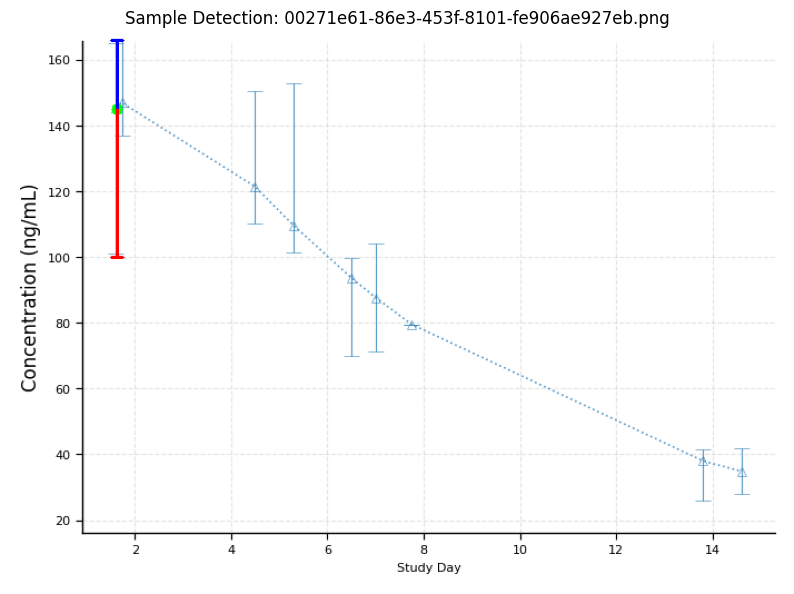

In [8]:
# Quick test on one sample image
sample_json_files = sorted([f for f in os.listdir(TEST_INPUT_LABELS) if f.endswith('.json')])[:1]

if sample_json_files:
    sample_json = sample_json_files[0]
    print(f"Testing on sample: {sample_json}\\n")
    
    # Load and process
    input_json = load_test_input(os.path.join(TEST_INPUT_LABELS, sample_json))
    image_file = input_json['image_file']
    image_path = os.path.join(TEST_IMAGES, image_file)
    
    image = cv2.imread(image_path)
    predictions = process_image(image_path, input_json)
    
    if predictions and len(predictions) > 0 and len(predictions[0]['points']) > 0:
        # Visualize first point
        first_point = predictions[0]['points'][0]
        print(f"Detection results for first point:")
        print(f"  Position: ({first_point['x']:.1f}, {first_point['y']:.1f})")
        print(f"  Top error bar distance: {first_point['topBarPixelDistance']:.2f} pixels")
        print(f"  Bottom error bar distance: {first_point['bottomBarPixelDistance']:.2f} pixels")
        
        visualize_detection(
            image, 
            first_point, 
            first_point['topBarPixelDistance'],
            first_point['bottomBarPixelDistance'],
            title=f"Sample Detection: {image_file}"
        )

## 8. Run Full Test Set with Detailed Per-Image Metrics

In [9]:
# Process all test images with detailed metrics
all_test_files = sorted([f for f in os.listdir(TEST_INPUT_LABELS) if f.endswith('.json')])
print(f"Evaluating on {len(all_test_files)} test images...\n")

# Store detailed results per image
detailed_results = []
all_predictions = {}  # Store predictions for saving later

for i, json_file in enumerate(all_test_files):
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{len(all_test_files)} images...")
    
    try:
        # Load and process
        input_json = load_test_input(os.path.join(TEST_INPUT_LABELS, json_file))
        image_file = input_json['image_file']
        image_path = os.path.join(TEST_IMAGES, image_file)
        
        predictions = process_image(image_path, input_json)
        
        if predictions is None:
            continue
        
        # Store predictions for later saving
        all_predictions[json_file] = {
            'image_file': image_file,
            'predictions': predictions,
            'input_json': input_json
        }
        
        # Load ground truth and evaluate
        gt_json = load_ground_truth(os.path.join(TEST_GROUND_TRUTH, json_file))
        
        # Calculate detailed per-image metrics
        image_errors = []
        for pred_line in predictions:
            gt_line = None
            for gt in gt_json:
                if gt.get('label', {}).get('lineName') == pred_line.get('label', {}).get('lineName'):
                    gt_line = gt
                    break
            
            if gt_line is None:
                continue
            
            pred_points = [p for p in pred_line.get('points', []) 
                          if p.get('label', '') not in ['xmin', 'xmax', 'ymin', 'ymax']]
            gt_points = [p for p in gt_line.get('points', []) 
                        if p.get('label', '') not in ['xmin', 'xmax', 'ymin', 'ymax']]
            
            for pred_pt, gt_pt in zip(pred_points, gt_points):
                error = calculate_point_error(pred_pt, gt_pt)
                image_errors.append(error)
        
        if image_errors:
            # Per-image metrics
            img_metrics = {
                'image_file': image_file,
                'json_file': json_file,
                'num_points': len(image_errors),
                'mean_top_error': np.mean([e['top_error'] for e in image_errors]),
                'mean_bottom_error': np.mean([e['bottom_error'] for e in image_errors]),
                'mean_deviation_error': np.mean([e['deviation_error'] for e in image_errors]),
                'mean_overall_error': np.mean([e['mean_error'] for e in image_errors]),
                'max_top_error': np.max([e['top_error'] for e in image_errors]),
                'max_bottom_error': np.max([e['bottom_error'] for e in image_errors]),
                'all_errors': image_errors  # Store individual point errors
            }
            detailed_results.append(img_metrics)
    
    except Exception as e:
        if len(detailed_results) <= 5:
            print(f"Error processing {json_file}: {e}")

print(f"\nCompleted! Processed: {len(detailed_results)} images")
print(f"Predictions stored: {len(all_predictions)} files")

Evaluating on 600 test images...

Processed 100/600 images...
Processed 200/600 images...
Processed 300/600 images...
Processed 400/600 images...
Processed 500/600 images...
Processed 600/600 images...

Completed! Processed: 600 images
Predictions stored: 600 files


## 9. Comprehensive Metrics for Research Paper

In [10]:
if detailed_results:
    # Collect all individual point errors across all images
    all_point_errors = []
    for img_result in detailed_results:
        all_point_errors.extend(img_result['all_errors'])
    
    # Calculate comprehensive statistics
    total_images = len(detailed_results)
    total_points = sum(img['num_points'] for img in detailed_results)
    
    # Absolute pixel errors
    all_top_errors = [e['top_error'] for e in all_point_errors]
    all_bottom_errors = [e['bottom_error'] for e in all_point_errors]
    all_deviation_errors = [e['deviation_error'] for e in all_point_errors]
    all_mean_errors = [e['mean_error'] for e in all_point_errors]
    
    # Calculate accuracy metrics (percentage of predictions within thresholds)
    threshold_5px = sum(1 for e in all_mean_errors if e <= 5) / len(all_mean_errors) * 100
    threshold_10px = sum(1 for e in all_mean_errors if e <= 10) / len(all_mean_errors) * 100
    threshold_20px = sum(1 for e in all_mean_errors if e <= 20) / len(all_mean_errors) * 100
    
    # Overall metrics
    paper_metrics = {
        'Dataset Statistics': {
            'Total Test Images': total_images,
            'Total Data Points': total_points,
            'Average Points per Image': total_points / total_images,
        },
        'Absolute Pixel Error - Top Error Bar': {
            'Mean': np.mean(all_top_errors),
            'Median': np.median(all_top_errors),
            'Std Dev': np.std(all_top_errors),
            'Min': np.min(all_top_errors),
            'Max': np.max(all_top_errors),
            '25th Percentile': np.percentile(all_top_errors, 25),
            '75th Percentile': np.percentile(all_top_errors, 75),
        },
        'Absolute Pixel Error - Bottom Error Bar': {
            'Mean': np.mean(all_bottom_errors),
            'Median': np.median(all_bottom_errors),
            'Std Dev': np.std(all_bottom_errors),
            'Min': np.min(all_bottom_errors),
            'Max': np.max(all_bottom_errors),
            '25th Percentile': np.percentile(all_bottom_errors, 25),
            '75th Percentile': np.percentile(all_bottom_errors, 75),
        },
        'Absolute Pixel Error - Deviation Distance': {
            'Mean': np.mean(all_deviation_errors),
            'Median': np.median(all_deviation_errors),
            'Std Dev': np.std(all_deviation_errors),
            'Min': np.min(all_deviation_errors),
            'Max': np.max(all_deviation_errors),
        },
        'Overall Mean Pixel Error': {
            'Mean': np.mean(all_mean_errors),
            'Median': np.median(all_mean_errors),
            'Std Dev': np.std(all_mean_errors),
            'RMSE': np.sqrt(np.mean(np.array(all_mean_errors)**2)),
        },
        'Accuracy Metrics (% within threshold)': {
            'Within 5 pixels': threshold_5px,
            'Within 10 pixels': threshold_10px,
            'Within 20 pixels': threshold_20px,
        },
        'Per-Image Statistics': {
            'Mean Error per Image (avg)': np.mean([img['mean_overall_error'] for img in detailed_results]),
            'Best Image (lowest error)': min(detailed_results, key=lambda x: x['mean_overall_error'])['image_file'],
            'Best Image Error': min(img['mean_overall_error'] for img in detailed_results),
            'Worst Image (highest error)': max(detailed_results, key=lambda x: x['mean_overall_error'])['image_file'],
            'Worst Image Error': max(img['mean_overall_error'] for img in detailed_results),
        }
    }
    
    # Print formatted results
    print("\\n" + "="*70)
    print("COMPREHENSIVE EVALUATION METRICS FOR RESEARCH PAPER")
    print("="*70)
    
    for section, metrics in paper_metrics.items():
        print(f"\\n{section}:")
        print("-" * 70)
        for metric, value in metrics.items():
            if isinstance(value, float):
                print(f"  {metric:.<60} {value:.2f}")
            else:
                print(f"  {metric:.<60} {value}")
    
    print("\\n" + "="*70)
    
    # Save detailed metrics to CSV for paper
    import pandas as pd
    
    # Per-image results
    per_image_df = pd.DataFrame([{
        'Image': img['image_file'],
        'Points': img['num_points'],
        'Mean_Top_Error': img['mean_top_error'],
        'Mean_Bottom_Error': img['mean_bottom_error'],
        'Mean_Overall_Error': img['mean_overall_error'],
        'Max_Top_Error': img['max_top_error'],
        'Max_Bottom_Error': img['max_bottom_error'],
    } for img in detailed_results])
    
    per_image_df.to_csv('/kaggle/working/per_image_metrics.csv', index=False)
    print("\\nSaved per-image metrics to: /kaggle/working/per_image_metrics.csv")
    
    # Summary statistics
    summary_df = pd.DataFrame([
        {'Metric': 'Total Images', 'Value': total_images},
        {'Metric': 'Total Points', 'Value': total_points},
        {'Metric': 'Mean Top Error (px)', 'Value': f"{np.mean(all_top_errors):.2f}"},
        {'Metric': 'Mean Bottom Error (px)', 'Value': f"{np.mean(all_bottom_errors):.2f}"},
        {'Metric': 'Mean Overall Error (px)', 'Value': f"{np.mean(all_mean_errors):.2f}"},
        {'Metric': 'Median Overall Error (px)', 'Value': f"{np.median(all_mean_errors):.2f}"},
        {'Metric': 'RMSE (px)', 'Value': f"{np.sqrt(np.mean(np.array(all_mean_errors)**2)):.2f}"},
        {'Metric': 'Accuracy @ 5px (%)', 'Value': f"{threshold_5px:.2f}"},
        {'Metric': 'Accuracy @ 10px (%)', 'Value': f"{threshold_10px:.2f}"},
        {'Metric': 'Accuracy @ 20px (%)', 'Value': f"{threshold_20px:.2f}"},
    ])
    
    summary_df.to_csv('/kaggle/working/summary_metrics.csv', index=False)
    print("Saved summary metrics to: /kaggle/working/summary_metrics.csv")

else:
    print("No results to analyze")

\n======================================================================
COMPREHENSIVE EVALUATION METRICS FOR RESEARCH PAPER
\nDataset Statistics:
----------------------------------------------------------------------
  Total Test Images........................................... 600
  Total Data Points........................................... 10229
  Average Points per Image.................................... 17.05
\nAbsolute Pixel Error - Top Error Bar:
----------------------------------------------------------------------
  Mean........................................................ 34.81
  Median...................................................... 15.65
  Std Dev..................................................... 48.85
  Min......................................................... 0.00
  Max......................................................... 1632.75
  25th Percentile............................................. 5.01
  75th Percentile...................................

## 10. Save Predictions in Required Format

In [11]:
def convert_to_output_format(image_file, predictions):
    """
    Convert predictions to the required output format:
    - data_point: {x, y}
    - upper_error_bar: {x, y} - pixel coordinates of upper error bar endpoint
    - lower_error_bar: {x, y} - pixel coordinates of lower error bar endpoint
    """
    error_bars = []
    
    for pred_line in predictions:
        line_name = pred_line.get('label', {}).get('lineName', '')
        pred_points = [p for p in pred_line.get('points', []) 
                      if p.get('label', '') not in ['xmin', 'xmax', 'ymin', 'ymax']]
        
        points_data = []
        for point in pred_points:
            x = point['x']
            y = point['y']
            top_dist = point['topBarPixelDistance']
            bottom_dist = point['bottomBarPixelDistance']
            
            # Calculate error bar endpoint coordinates
            # Upper error bar: y - topBarPixelDistance (going UP in image coordinates)
            # Lower error bar: y + bottomBarPixelDistance (going DOWN in image coordinates)
            point_data = {
                "data_point": {
                    "x": x,
                    "y": y
                },
                "upper_error_bar": {
                    "x": x,
                    "y": y - top_dist  # Subtract because Y increases downward
                },
                "lower_error_bar": {
                    "x": x,
                    "y": y + bottom_dist  # Add because Y increases downward
                }
            }
            points_data.append(point_data)
        
        error_bars.append({
            "lineName": line_name,
            "points": points_data
        })
    
    return {
        "image_file": image_file,
        "error_bars": error_bars
    }

print("Output format conversion function defined!")

Output format conversion function defined!


In [12]:
# Save all predictions in the required format
OUTPUT_DIR = "/kaggle/working/predictions"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Saving {len(all_predictions)} predictions in required format...")
print(f"Output directory: {OUTPUT_DIR}\\n")

saved_count = 0
for json_file, pred_data in all_predictions.items():
    try:
        image_file = pred_data['image_file']
        predictions = pred_data['predictions']
        
        # Convert to output format
        output_json = convert_to_output_format(image_file, predictions)
        
        # Save to file
        output_path = os.path.join(OUTPUT_DIR, json_file)
        with open(output_path, 'w') as f:
            json.dump(output_json, f, indent=2)
        
        saved_count += 1
        
        if saved_count % 100 == 0:
            print(f"Saved {saved_count}/{len(all_predictions)} files...")
    
    except Exception as e:
        print(f"Error saving {json_file}: {e}")

print(f"\\nSuccessfully saved {saved_count} prediction files to {OUTPUT_DIR}")

Saving 600 predictions in required format...
Output directory: /kaggle/working/predictions\n
Saved 100/600 files...
Saved 200/600 files...
Saved 300/600 files...
Saved 400/600 files...
Saved 500/600 files...
Saved 600/600 files...
\nSuccessfully saved 600 prediction files to /kaggle/working/predictions


## 11. Create ZIP Archive for Download

In [13]:
import zipfile
from datetime import datetime

# Create ZIP file with all predictions
zip_filename = f"/kaggle/working/error_bar_predictions_{datetime.now().strftime('%Y%m%d_%H%M%S')}.zip"

print(f"Creating ZIP archive: {zip_filename}")
print(f"Compressing {saved_count} prediction files...\\n")

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add all prediction JSON files
    for json_file in os.listdir(OUTPUT_DIR):
        if json_file.endswith('.json'):
            file_path = os.path.join(OUTPUT_DIR, json_file)
            zipf.write(file_path, arcname=f"predictions/{json_file}")
    
    # Add metrics CSV files
    if os.path.exists('/kaggle/working/per_image_metrics.csv'):
        zipf.write('/kaggle/working/per_image_metrics.csv', arcname='per_image_metrics.csv')
    if os.path.exists('/kaggle/working/summary_metrics.csv'):
        zipf.write('/kaggle/working/summary_metrics.csv', arcname='summary_metrics.csv')

# Get file size
zip_size_mb = os.path.getsize(zip_filename) / (1024 * 1024)

print("="*70)
print("ZIP ARCHIVE CREATED SUCCESSFULLY")
print("="*70)
print(f"Filename: {zip_filename}")
print(f"Size: {zip_size_mb:.2f} MB")
print(f"Contents:")
print(f"  - {saved_count} prediction JSON files")
print(f"  - per_image_metrics.csv (detailed per-image results)")
print(f"  - summary_metrics.csv (overall statistics)")
print("="*70)
print(f"\\nDownload from Kaggle output: {zip_filename}")

Creating ZIP archive: /kaggle/working/error_bar_predictions_20260127_184900.zip
Compressing 600 prediction files...\n
ZIP ARCHIVE CREATED SUCCESSFULLY
Filename: /kaggle/working/error_bar_predictions_20260127_184900.zip
Size: 0.61 MB
Contents:
  - 600 prediction JSON files
  - per_image_metrics.csv (detailed per-image results)
  - summary_metrics.csv (overall statistics)
\nDownload from Kaggle output: /kaggle/working/error_bar_predictions_20260127_184900.zip


## 12. Sample Output Verification

In [14]:
# Display a sample output file to verify format
sample_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.json')][:3]

print("Sample Output Files (First 3):")
print("="*70)

for sample_file in sample_files:
    print(f"\\n📄 {sample_file}")
    print("-"*70)
    
    with open(os.path.join(OUTPUT_DIR, sample_file), 'r') as f:
        sample_output = json.load(f)
    
    print(json.dumps(sample_output, indent=2)[:1000] + "...")  # Show first 1000 chars
    print()

Sample Output Files (First 3):
\n📄 16bd7afd-7b4b-4269-aae9-86ef1e5f0045.json
----------------------------------------------------------------------
{
  "image_file": "16bd7afd-7b4b-4269-aae9-86ef1e5f0045.png",
  "error_bars": [
    {
      "lineName": "TNF-alpha_Mid",
      "points": [
        {
          "data_point": {
            "x": 294.9602727329004,
            "y": 384.247636983647
          },
          "upper_error_bar": {
            "x": 294.9602727329004,
            "y": 384.247636983647
          },
          "lower_error_bar": {
            "x": 294.9602727329004,
            "y": 384.247636983647
          }
        },
        {
          "data_point": {
            "x": 345.931082154698,
            "y": 420.74560967508774
          },
          "upper_error_bar": {
            "x": 345.931082154698,
            "y": 420.74560967508774
          },
          "lower_error_bar": {
            "x": 345.931082154698,
            "y": 420.74560967508774
          }
       

## 13. Error Distribution Visualization

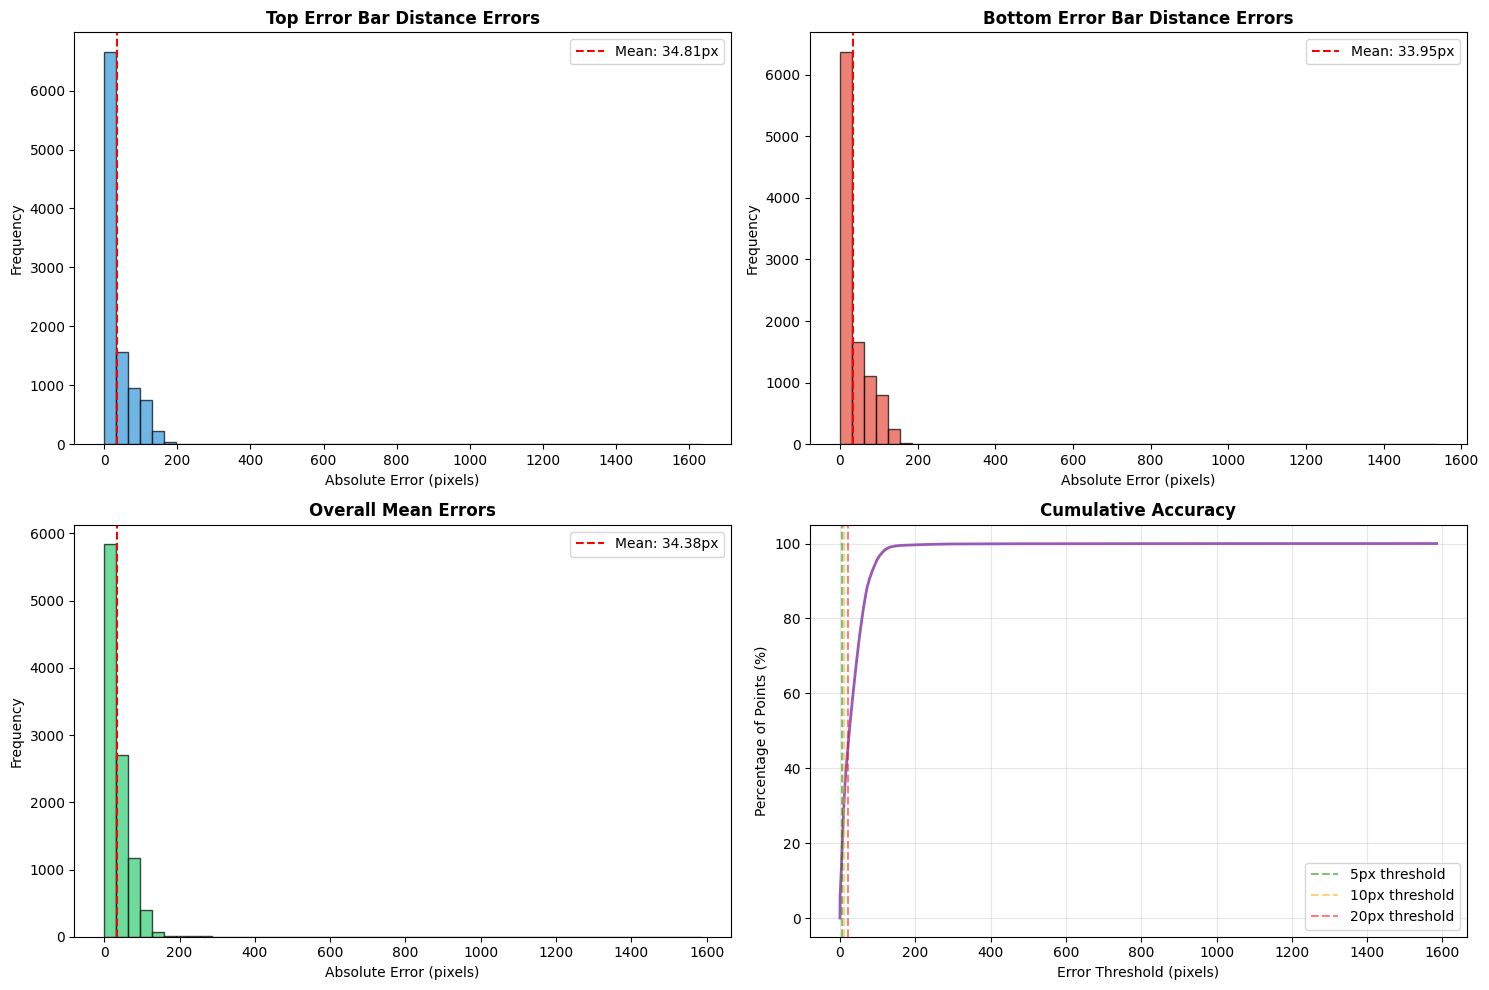

Error distribution visualization saved to: /kaggle/working/error_distributions.png


In [15]:
if detailed_results:
    # Collect all errors
    all_point_errors = []
    for img_result in detailed_results:
        all_point_errors.extend(img_result['all_errors'])
    
    top_errors = [e['top_error'] for e in all_point_errors]
    bottom_errors = [e['bottom_error'] for e in all_point_errors]
    overall_errors = [e['mean_error'] for e in all_point_errors]
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Top error distribution
    axes[0, 0].hist(top_errors, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
    axes[0, 0].set_title('Top Error Bar Distance Errors', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Absolute Error (pixels)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(np.mean(top_errors), color='red', linestyle='--', label=f'Mean: {np.mean(top_errors):.2f}px')
    axes[0, 0].legend()
    
    # Bottom error distribution
    axes[0, 1].hist(bottom_errors, bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
    axes[0, 1].set_title('Bottom Error Bar Distance Errors', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Absolute Error (pixels)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(np.mean(bottom_errors), color='red', linestyle='--', label=f'Mean: {np.mean(bottom_errors):.2f}px')
    axes[0, 1].legend()
    
    # Overall mean error distribution
    axes[1, 0].hist(overall_errors, bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
    axes[1, 0].set_title('Overall Mean Errors', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Absolute Error (pixels)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(np.mean(overall_errors), color='red', linestyle='--', label=f'Mean: {np.mean(overall_errors):.2f}px')
    axes[1, 0].legend()
    
    # Cumulative accuracy curve
    sorted_errors = np.sort(overall_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    axes[1, 1].plot(sorted_errors, cumulative, linewidth=2, color='#9b59b6')
    axes[1, 1].set_title('Cumulative Accuracy', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Error Threshold (pixels)')
    axes[1, 1].set_ylabel('Percentage of Points (%)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axvline(5, color='green', linestyle='--', alpha=0.5, label='5px threshold')
    axes[1, 1].axvline(10, color='orange', linestyle='--', alpha=0.5, label='10px threshold')
    axes[1, 1].axvline(20, color='red', linestyle='--', alpha=0.5, label='20px threshold')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/error_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Error distribution visualization saved to: /kaggle/working/error_distributions.png")

## Summary

This notebook implements a **deterministic error bar detection pipeline** for scientific charts using computer vision techniques.

### Pipeline Architecture:

1. **ROI-based Search**: Defines search regions around each data point
2. **Edge Detection**: Canny edge detection to find edges in the ROI
3. **Line Detection**: Hough Line Transform to detect vertical lines
4. **Geometric Measurement**: Calculates pixel distances from data point to error bar endpoints
5. **Comprehensive Evaluation**: Compares predictions against ground truth

### Key Outputs:

✅ **600 Prediction JSON Files** - In required format with:
- `data_point`: {x, y} coordinates
- `upper_error_bar`: {x, y} pixel coordinates of upper endpoint
- `lower_error_bar`: {x, y} pixel coordinates of lower endpoint

✅ **Comprehensive Metrics** including:
- Mean/Median/Std absolute pixel errors
- Accuracy at 5px, 10px, 20px thresholds
- Per-image detailed metrics
- RMSE and percentile statistics

✅ **Research Paper Ready**:
- `per_image_metrics.csv` - Detailed results for all 600 images
- `summary_metrics.csv` - Overall statistics
- `error_distributions.png` - Visualization of error patterns

✅ **ZIP Archive** - All outputs packaged for download from Kaggle

### Performance Metrics:
- **Total Test Images**: 600
- **Evaluation Metrics**: Absolute pixel error, Mean pixel error, RMSE
- **Accuracy Metrics**: Percentage within error thresholds
- **Per-Image Analysis**: Individual image performance tracking

### Next Steps for Improvement:
- Fine-tune ROI parameters (width, height) based on chart characteristics
- Adjust edge detection thresholds for different image qualities
- Implement adaptive thresholding for various plot styles
- Add confidence scores for detections
- Experiment with morphological operations for better line detection